https://www.science.org/doi/10.1126/science.1127647

https://github.com/L1aoXingyu/pytorch-beginner/blob/9c86be785c7c318a09cf29112dd1f1a58613239b/08-AutoEncoder/conv_autoencoder.py

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from pathlib import Path
from torch.utils.data import TensorDataset, DataLoader
from lib.modules import (
    evaluate_loop, 
    pad_for_windowing,
    window_session,
    optimization_loop
)
from tqdm import tqdm
import plotly.express as px
from datetime import timedelta

In [4]:
WINSIZE = 101
# DEVICE = 'cuda:0'
DEVICE = 'cpu'
RAW_DIR = Path('/home/musa/datasets/eating_raw/')

In [5]:
recordings = []
for rec_dir in RAW_DIR.iterdir():
    recordings.append(rec_dir)
    print(rec_dir.name)

FileNotFoundError: [Errno 2] No such file or directory: '/home/musa/datasets/eating_raw'

In [5]:
session_dir = recordings[3]
accel_file = session_dir / f'acceleration-{session_dir.name}.csv'
acceleration = pd.read_csv(accel_file,skiprows=1).rename({'x': 'x_acc', 'y': 'y_acc', 'z': 'z_acc'}, axis=1)
acceleration_start_time_seconds = float(pd.read_csv(session_dir / accel_file, nrows=1,header=None).iloc[0,0].split()[-1])/1000
acceleration.timestamp = ((acceleration.timestamp - acceleration.timestamp[0])*1e-9)+acceleration_start_time_seconds # get timestamp in seconds
acceleration = acceleration.dropna()
print(session_dir.name)
print(len(acceleration))
print(f'{timedelta(seconds=acceleration.timestamp.iloc[-1] - acceleration.timestamp.iloc[0])}')

10-27_09_45_42
2854125
7:37:03.002257


In [6]:
dim_amt = 5
fig = px.line(acceleration[::dim_amt], x=acceleration.index[::dim_amt], y=['x_acc','y_acc','z_acc'])
fig.show(renderer='browser')

In [6]:
Xtr = torch.Tensor(acceleration[['x_acc','y_acc','z_acc']].values)

# normalize
# Xtr = (Xtr - Xtr.mean()) / Xtr.std()
# Xtr = (Xtr - Xtr.mean()) / Xtr.std()

Xtr = pad_for_windowing(Xtr, WINSIZE)
Xtr = window_session(Xtr, WINSIZE)
trainloader = DataLoader(TensorDataset(Xtr), batch_size=64, shuffle=True)

In [7]:
# First: Autoencoder reduces input to 3 dimensions

class Autoencoder(nn.Module):
    def __init__(self, winsize):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(winsize*3, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(), 
            nn.Linear(64, 12), 
            nn.ReLU(True), 
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(), 
            nn.Linear(128, winsize*3)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = Autoencoder(winsize=WINSIZE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.MSELoss()

Epoch 29: Train Loss: 1.1938: 100%|██████████| 30/30 [28:56<00:00, 57.89s/it]


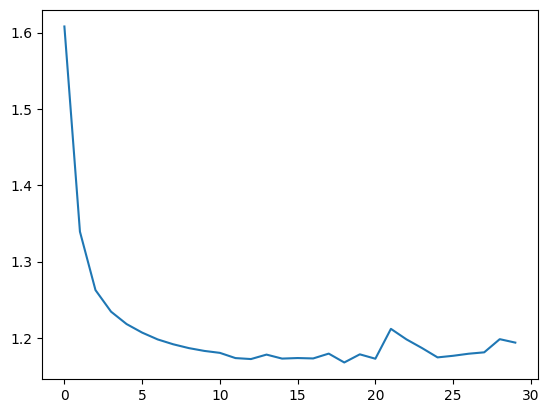

In [27]:
losses = []
pbar = tqdm(range(30))
for epoch in pbar:
    lossi = 0
    for X in trainloader:
        X = X[0].to(DEVICE)

        logits = model(X)
        loss = criterion(logits, X)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lossi += loss.item()

    losses.append(lossi/len(trainloader))
    pbar.set_description(f'Epoch {epoch}: Train Loss: {losses[-1]:.5}')

plt.plot(losses)

In [35]:
torch.save(model.state_dict(), 'dev/autoencorder.pt')

In [8]:
model.load_state_dict(torch.load('dev/autoencorder.pt'))

<All keys matched successfully>

In [9]:
# Recreate a signal wqith trained model
trainloader = DataLoader(TensorDataset(Xtr), batch_size=64)

Xpred = []
for X in tqdm(trainloader):
    X = X[0].to(DEVICE)

    logits = model(X)

    Xpred.append(logits)

Xpred = torch.cat(Xpred, dim=0)
Xpred = Xpred.view(-1,3,101)[:,:,50].T

100%|██████████| 44596/44596 [00:23<00:00, 1924.07it/s]


In [10]:
acceleration['x_pred'] = Xpred[0].detach()
acceleration['y_pred'] = Xpred[1].detach()
acceleration['z_pred'] = Xpred[2].detach()

In [11]:
dim_amt = 10
fig = px.line(acceleration[::dim_amt], x=acceleration.index[::dim_amt], y=['x_acc','y_acc','z_acc', 'x_pred', 'y_pred', 'z_pred'])
fig.show(renderer='browser')

: 